<a href="https://colab.research.google.com/github/starkjiang/TrAC-Interpretability/blob/main/module2_iia_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grad-CAM Tutorial

Grad CAM stands for Gradient-weighted Class Activation Map. They are used to generate heatmaps which highlights the important region of the image that contribute the way a model performs as it does.
For example: In an image classification model, it highlights the important region of the image that contribute the model prediction of a certain class (say cat). It will be more clear once we code it out.

The step wise process to generate CAMs are as follows:

1. First, you need to decide for which class and convolutional layer in the neural network the CAM is to be generated.

2. Then, calculate the activations simply by passing the input to the convolutional layer.

3. Fetch the gradient values from the same layer with respect to the class.

4. Calculate the mean of the gradients within each output channel.

5. Calculate the weighted activation map and then compute mean.

6. Upscale the weighted activation map outputs to the same size as the input of the image.

7. Finally, overlay the activation map onto the input image.

Now, lets move into the coding part that will make the steps more clear. We will define two main functions one to generate heatmap and to up sample the heatmap.

Note: Here, we will be using pretrained model (vgg16) to generate activation map.

In [ ]:
# Import necessary packages and libraries.
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms as transforms

import warnings
warnings.filterwarnings('ignore')

from PIL import Image


# Load pre-trained model.
vgg_model = models.vgg16(pretrained=True)

# Transformation for passing image into the network.
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Selecting layers from the model to generate activations.
image_to_heatmaps = nn.Sequential(*list(vgg_model.features[:-4]))

In [ ]:
def compute_heatmap(model,img):
  model.eval()
  # Compute logits from the model.
  logits = model(img)
  # Model's prediction.
  pred = logits.max(-1)[-1]
  # Activations from the model.
  activations = image_to_heatmaps(img)
  # Compute gradients with respect to the model's most confident prediction.
  logits[0, pred].backward(retain_graph=True)
  # Average gradients of the features.
  pool_grads = model.features[-3].weight.grad.data.mean((0,2,3))
  # Multiply each activation map with corresponding gradient average.
  for i in range(activations.shape[1]):
    activations[:,i,:,:] *= pool_grads[i]
  # Calculate mean of weighted activations.
  heatmap = torch.mean(activations, dim=1)[0].cpu().detach()
  return heatmap, pred

In [ ]:
def upsample_heatmap(map, image):
  # Permute image.
  image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
  # Maximum and minimum value from heatmap.
  m, M = map.min(), map.max()
  # Normalize the heatmap.
  map = 255 * ((map-m)/ (m-M))
  map = np.uint8(map)
  # Resize the heatmap to the same as the input.
  map = cv2.resize(map, (224, 224))
  map = cv2.applyColorMap(255-map, cv2.COLORMAP_JET)
  map = np.uint8(map)
  # Change this to balance between heatmap and image.
  map = np.uint8(map*0.7 + image*0.3)
  return map

In [ ]:
def display_images(upsampled_map, image):
    image = image.squeeze(0).permute(1, 2, 0)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(upsampled_map)
    axes[0].set_title("Heatmap")
    axes[0].axis('off')
    axes[1].imshow(image)
    axes[1].set_title("Original Image")
    axes[1].axis('off')
    plt.show()

Prediction: tensor([208])


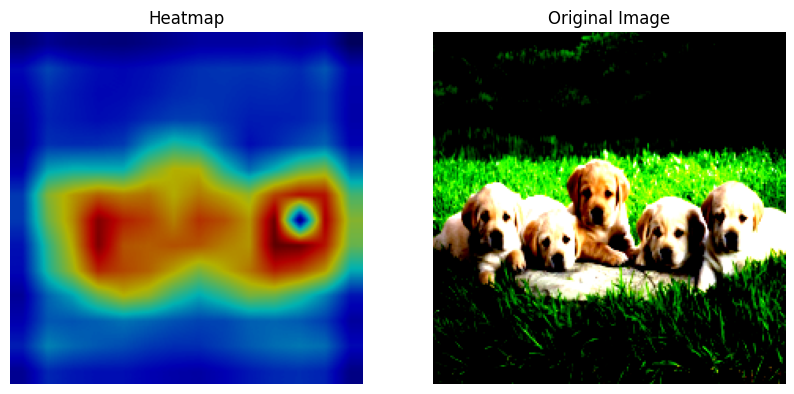

In [ ]:
# Example usage.
# image_url = "https://th.bing.com/th/id/OIP.CmONj_pGCXg9Hq9-OxTD9gHaEo?pid=ImgDet&rs=1"
image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/tutorials/puppies.jpg"
# image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
# image_url = "https://th.bing.com/th/id/R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg&riu=http%3a%2f%2fimages5.fanpop.com%2fimage%2fphotos%2f31400000%2fBear-Wallpaper-bears-31446777-1600-1200.jpg&ehk=oD0JPpRVTZZ6yizZtGQtnsBGK2pAap2xv3sU3A4bIMc%3d&risl=&pid=ImgRaw&r=0"
img = Image.open(requests.get(image_url, stream=True).raw)
img = transform(img)

img = img.unsqueeze(0)
heatmap, pred = compute_heatmap(vgg_model, img)
upsampled_map = upsample_heatmap(heatmap, img)
print(f"Prediction: {pred}")

display_images(upsampled_map, img)

From the paper, “Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization”, Grad CAM are very much applicable to wide range of CNN networks like:
i. CNNs with fully-connected layers.
ii. CNNs used for structured outputs.
iii. CNNS used in tasks with multi-modal inputs or reinforcement learning.

You can read more about Grad-CAM in https://arxiv.org/abs/1610.02391.

In [ ]:
"""Instead, you can also use the customized PyTorch package for Grad-CAM. Then
you have to install using the following command:"""
# !pip install grad-cam

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 141MB/s]


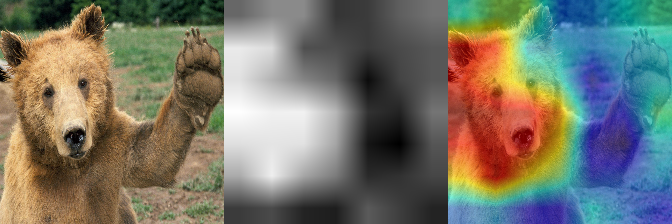

In [ ]:
import requests

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image

model = models.resnet50(pretrained=True)
model.eval()
image_url = "https://th.bing.com/th/id/R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg&riu=http%3a%2f%2fimages5.fanpop.com%2fimage%2fphotos%2f31400000%2fBear-Wallpaper-bears-31446777-1600-1200.jpg&ehk=oD0JPpRVTZZ6yizZtGQtnsBGK2pAap2xv3sU3A4bIMc%3d&risl=&pid=ImgRaw&r=0"
img = np.array(Image.open(requests.get(image_url, stream=True).raw))
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(
    img,
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
targets = [ClassifierOutputTarget(295)]
target_layers = [model.layer4]
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

The confidence increase percent: 0.010517926421016455
The visualization of the pertubated image for the metric:


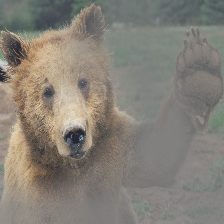

In [ ]:
# Now lets see how to evaluate this explanation:
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget

# For the metrics we want to measure the change in the confidence, after
# softmax, that's why we use ClassifierOutputSoftmaxTarget.
targets = [ClassifierOutputSoftmaxTarget(295)]
cam_metric = CamMultImageConfidenceChange()
scores, visualizations = cam_metric(
    input_tensor,
    grayscale_cams,
    targets,
    model,
    return_visualization=True
)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase percent: {100*score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

In [ ]:
from pytorch_grad_cam.metrics.cam_mult_image import DropInConfidence, IncreaseInConfidence
print(
    "Drop in confidence", DropInConfidence()(
        input_tensor, grayscale_cams, targets, model)
)
print("Increase in confidence",
      IncreaseInConfidence()(input_tensor, grayscale_cams, targets, model)
)

Drop in confidence [0.]
Increase in confidence [1.]


The confidence increase percent: 0.0002188471844419837
The visualization of the pertubated image for the metric:


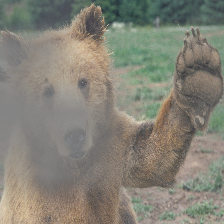

In [ ]:
inverse_cams = 1 - grayscale_cams
scores, visualizations = CamMultImageConfidenceChange()(
    input_tensor,
    inverse_cams,
    targets,
    model,
    return_visualization=True
)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase percent: {score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

The confidence increase: -0.0014819047646597028
The visualization of the pertubated image for the metric:


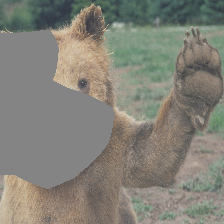

In [ ]:
thresholded_cam = grayscale_cams < np.percentile(grayscale_cams, 75)
scores, visualizations = CamMultImageConfidenceChange()(
    input_tensor,
    thresholded_cam,
    targets,
    model,
    return_visualization=True
)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase: {score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

The confidence increase: -0.0008427721913903952
The visualization of the pertubated image for the metric:


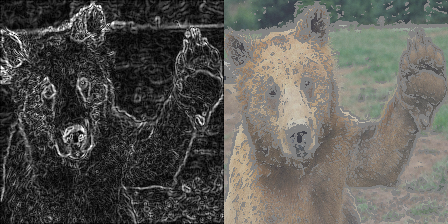

In [ ]:
from pytorch_grad_cam.sobel_cam import sobel_cam

sobel_cam_grayscale = sobel_cam(np.uint8(img * 255))
thresholded_cam = sobel_cam_grayscale < np.percentile(sobel_cam_grayscale, 75)

cam_metric = CamMultImageConfidenceChange()
scores, visualizations = cam_metric(
    input_tensor,
     [thresholded_cam],
    targets,
    model,
    return_visualization=True
)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase: {score}")
print("The visualization of the pertubated image for the metric:")
sobel_cam_rgb = cv2.merge(
    [sobel_cam_grayscale,
     sobel_cam_grayscale,
     sobel_cam_grayscale])
Image.fromarray(np.hstack((sobel_cam_rgb, visualization)))

The confidence increase when removing 25% of the image: -0.0014757482567802072
The confidence increase when removing 10% of the image: -0.0012796417577192187
The visualizations:


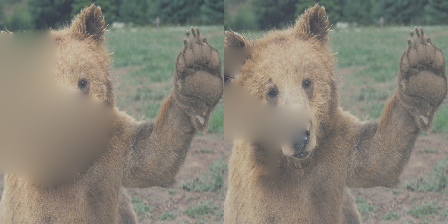

In [ ]:
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirst
cam_metric = ROADMostRelevantFirst(percentile=75)
scores, visualizations = cam_metric(
    input_tensor,
    grayscale_cams,
    targets,
    model,
    return_visualization=True
)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase when removing 25% of the image: {score}")

cam_metric = ROADMostRelevantFirst(percentile=90)
scores, visualizations = cam_metric(
    input_tensor,
    grayscale_cams,
    targets,
    model,
    return_visualization=True
)
score = scores[0]
visualization_10 = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization_10 = deprocess_image(visualization_10)
print(f"The confidence increase when removing 10% of the image: {score}")
print("The visualizations:")
Image.fromarray(np.hstack((visualization, visualization_10)))